In [1]:
!pip install -q flwr

In [2]:
!pip install -U flwr

In [3]:
# --- Imports ---
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import gc
import flwr as fl
from flwr.client import NumPyClient
from flwr.common import Context
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
import time

# --- Load and prepare data ---
data = np.load("/kaggle/input/daicwoz-balanced/dataset_balanced.npz")
test_ids = np.load("/kaggle/input/daicwoz-balanced/test_ids (1).npy")

X_audio_test = data["X_audio_test"]
X_text_test = data["X_text_test"]
y_test = data["y_test"]

X_audio_dev = data["X_audio_dev"]
X_text_dev = data["X_text_dev"]
y_dev = data["y_dev"]

X_audio_train = data["X_audio_train"]
X_text_train = data["X_text_train"]
y_train = data["y_train"]

y_train = y_train.reshape(-1, 1)
y_dev = y_dev.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# --- Parameters ---
NUM_CLIENTS = 10
input_shape_audio = (378, 60)
input_shape_text = (378, 9)

# --- Build model ---
def build_model():
    input_audio = layers.Input(shape=input_shape_audio, name='mfcc_input')
    x_audio = layers.LSTM(60, return_sequences=True, recurrent_dropout=0.002,
                          bias_regularizer=regularizers.l1_l2(1e-4, 1e-4))(input_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(40, return_sequences=True, recurrent_dropout=0.002,
                          bias_regularizer=regularizers.l1_l2(1e-4, 1e-4))(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002,
                          bias_regularizer=regularizers.l1_l2(1e-4, 1e-4))(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)

    input_text = layers.Input(shape=input_shape_text, name='text_input')
    x_text = layers.Flatten()(input_text)

    x = layers.Concatenate()([x_audio, x_text])
    x = layers.Reshape((1, -1))(x)
    x = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(2e-4)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(15, activation='tanh')(x)
    x = layers.Dense(10, activation='tanh')(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs=[input_audio, input_text], outputs=output)

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def compile_model():
    model = build_model()
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(1e-5),
        loss=rmse,
        metrics=['accuracy', 'mae', rmse]
    )
    return model

def split_data(num_clients):
    size = len(y_train) // num_clients
    return [
        (X_audio_train[i * size : (i + 1) * size if i != num_clients - 1 else None],
         X_text_train[i * size : (i + 1) * size if i != num_clients - 1 else None],
         y_train[i * size : (i + 1) * size if i != num_clients - 1 else None])
        for i in range(num_clients)
    ]

client_datasets = split_data(NUM_CLIENTS)

# --- Global Metrics ---
global_metrics = {
    "accuracy": [],
    "mae": [],
    "rmse": [],
    "f1_score": [],
    "precision": [],
    "recall": [],
    "comm_bytes": [],
    "round_time_sec": []
}

def get_model_size(weights):
    return sum([w.nbytes for w in weights])

# --- Flower Client ---
class DepressionClient(NumPyClient):
    def __init__(self, model, X_audio_c, X_text_c, y_c):
        self.model = model
        self.X_audio_train = X_audio_c
        self.X_text_train = X_text_c
        self.y_train = y_c
        self.X_audio_test = X_audio_dev
        self.X_text_test = X_text_dev
        self.y_test = y_dev

    def get_parameters(self, config=None):
        return self.model.get_weights()

    def set_parameters(self, parameters):
        self.model.set_weights(parameters)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.fit(
            [self.X_audio_train, self.X_text_train],
            self.y_train,
            batch_size=16,
            epochs=2,
            verbose=0,
            shuffle=True,
        )
        return self.get_parameters(), len(self.y_train), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, acc, mae, rmse_val = self.model.evaluate(
            [self.X_audio_test, self.X_text_test], self.y_test, verbose=1
        )
        return float(loss), len(self.y_test), {
            "accuracy": float(acc),
            "mae": float(mae),
            "rmse": float(rmse_val)
        }

# --- Client App ---
def client_fn(context: Context):
    partition_id = int(context.node_config.get("partition-id", 0))
    model = compile_model()
    X_audio_c, X_text_c, y_c = client_datasets[partition_id]
    return DepressionClient(model, X_audio_c, X_text_c, y_c).to_client()

client_app = fl.client.ClientApp(client_fn=client_fn)

# --- Server App ---
def server_fn(context: Context) -> ServerAppComponents:
    model = compile_model()

    def evaluate_fn(server_round, parameters, _config):
        start = time.time()

        model.set_weights(parameters)
        y_pred = model.predict([X_audio_test, X_text_test])
        y_pred_labels = (y_pred > 0.5).astype(int)

        acc = accuracy_score(y_test, y_pred_labels)
        f1 = f1_score(y_test, y_pred_labels)
        prec = precision_score(y_test, y_pred_labels)
        rec = recall_score(y_test, y_pred_labels)
        mae_val = np.mean(np.abs(y_test - y_pred))
        rmse_val = np.sqrt(np.mean((y_test - y_pred) ** 2))

        bytes_per_round = get_model_size(parameters) * NUM_CLIENTS * 2
        round_time = time.time() - start

        global_metrics["accuracy"].append(acc)
        global_metrics["mae"].append(mae_val)
        global_metrics["rmse"].append(rmse_val)
        global_metrics["f1_score"].append(f1)
        global_metrics["precision"].append(prec)
        global_metrics["recall"].append(rec)
        global_metrics["comm_bytes"].append(bytes_per_round)
        global_metrics["round_time_sec"].append(round_time)

        print(f"\n\U0001F4CA Round {server_round}: Acc={acc:.4f}, F1={f1:.4f}, MAE={mae_val:.4f}, RMSE={rmse_val:.4f}, Bytes={bytes_per_round}, Time={round_time:.2f}s")

        tf.keras.backend.clear_session()
        gc.collect()

        return float(rmse_val), {
            "accuracy": float(acc),
            "f1_score": float(f1),
            "precision": float(prec),
            "recall": float(rec),
            "mae": float(mae_val),
            "rmse": float(rmse_val),
            "comm_bytes": bytes_per_round,
            "round_time_sec": round_time
        }

    strategy = FedAvg(
        fraction_fit=0.8,
        fraction_evaluate=0.5,
        min_fit_clients=NUM_CLIENTS,
        min_evaluate_clients=5,
        min_available_clients=NUM_CLIENTS,
        evaluate_fn=evaluate_fn,
    )

    return ServerAppComponents(strategy=strategy, config=ServerConfig(num_rounds=5))

server_app = ServerApp(server_fn=server_fn)

# --- Backend Resources ---
DEVICE = "cpu"
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

# --- Run Simulation ---
run_simulation(
    server_app=server_app,
    client_app=client_app,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

2025-07-03 21:05:15.017213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751576715.047133   14756 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751576715.055772   14756 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-03 21:05:29.362222: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=15119) 2025-07-03 21:05:38.926111: E external/local_xla/xla/stream_executor

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step

📊 Round 0: Acc=0.4935, F1=0.6042, MAE=0.4996, RMSE=0.5000, Bytes=26125280, Time=10.56s


INFO :      initial parameters (loss, other metrics): 0.49997323751449585, {'accuracy': 0.49353448275862066, 'f1_score': 0.6041549691184728, 'precision': 0.49585253456221196, 'recall': 0.7729885057471264, 'mae': 0.4995916187763214, 'rmse': 0.49997323751449585, 'comm_bytes': 26125280, 'round_time_sec': 10.564535856246948}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=15119) 2025-07-03 21:06:01.440784: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(ClientAppActor pid=15115) 2025-07-03 21:06:01.441875: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step

📊 Round 1: Acc=0.5122, F1=0.4590, MAE=0.4999, RMSE=0.5009, Bytes=26125280, Time=8.20s


INFO :      fit progress: (1, 0.5008643865585327, {'accuracy': 0.5122126436781609, 'f1_score': 0.4589641434262948, 'precision': 0.5152057245080501, 'recall': 0.41379310344827586, 'mae': 0.49988240003585815, 'rmse': 0.5008643865585327, 'comm_bytes': 26125280, 'round_time_sec': 8.196907758712769}, 685.1936987489999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


 1/44 ━━━━━━━━━━━━━━━━━━━━ 4:42 7s/step - accuracy: 0.6562 - loss: 0.5261 - mae: 0.5014 - rmse: 0.5021
 2/44 ━━━━━━━━━━━━━━━━━━━━ 22s 547ms/step - accuracy: 0.6719 - loss: 0.5257 - mae: 0.5010 - rmse: 0.5017
 3/44 ━━━━━━━━━━━━━━━━━━━━ 21s 518ms/step - accuracy: 0.6875 - loss: 0.5251 - mae: 0.5004 - rmse: 0.5012
 1/44 ━━━━━━━━━━━━━━━━━━━━ 4:57 7s/step - accuracy: 0.6562 - loss: 0.5261 - mae: 0.5014 - rmse: 0.5021 [repeated 3x across cluster]
 2/44 ━━━━━━━━━━━━━━━━━━━━ 22s 530ms/step - accuracy: 0.6719 - loss: 0.5257 - mae: 0.5010 - rmse: 0.5017 [repeated 3x across cluster]
11/44 ━━━━━━━━━━━━━━━━━━━━ 20s 612ms/step - accuracy: 0.6521 - loss: 0.5255 - mae: 0.5007 - rmse: 0.5015 [repeated 30x across cluster]
15/44 ━━━━━━━━━━━━━━━━━━━━ 22s 763ms/step - accuracy: 0.6375 - loss: 0.5259 - mae: 0.5011 - rmse: 0.5019 [repeated 23x across cluster]
18/44 ━━━━━━━━━━━━━━━━━━━━ 24s 959ms/step - accuracy: 0.6291 - loss: 0.5262 - mae: 0.5014 - rmse: 0.5022 [repeated 9x across cluster]
26/44 ━━━━━━━━━━━

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step

📊 Round 2: Acc=0.4993, F1=0.4499, MAE=0.5017, RMSE=0.5043, Bytes=26125280, Time=10.76s


INFO :      fit progress: (2, 0.5043102502822876, {'accuracy': 0.4992816091954023, 'f1_score': 0.44988161010260463, 'precision': 0.4991243432574431, 'recall': 0.40948275862068967, 'mae': 0.5016878247261047, 'rmse': 0.5043102502822876, 'comm_bytes': 26125280, 'round_time_sec': 10.75942087173462}, 1453.7236381839994)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 4016 MiB, 4 objects, write throughput 192 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=15118) 2025-07-03 21:06:01.457274: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(raylet) Spilled 5020 MiB, 5 objects, write throughput 228 MiB/s.


 1/44 ━━━━━━━━━━━━━━━━━━━━ 7:36 11s/step - accuracy: 0.6875 - loss: 0.5185 - mae: 0.4922 - rmse: 0.4946
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.5695 - loss: 0.5266 - mae: 0.5017 - rmse: 0.5026 [repeated 7x across cluster]
 3/44 ━━━━━━━━━━━━━━━━━━━━ 19s 480ms/step - accuracy: 0.7240 - loss: 0.5168 - mae: 0.4906 - rmse: 0.4928
 1/44 ━━━━━━━━━━━━━━━━━━━━ 7:49 11s/step - accuracy: 0.6875 - loss: 0.5185 - mae: 0.4922 - rmse: 0.4946 [repeated 3x across cluster]
 2/44 ━━━━━━━━━━━━━━━━━━━━ 35s 850ms/step - accuracy: 0.7109 - loss: 0.5177 - mae: 0.4915 - rmse: 0.4938 [repeated 4x across cluster]
12/44 ━━━━━━━━━━━━━━━━━━━━ 17s 550ms/step - accuracy: 0.6964 - loss: 0.5177 - mae: 0.4913 - rmse: 0.4937 [repeated 33x across cluster]
23/44 ━━━━━━━━━━━━━━━━━━━━ 10s 508ms/step - accuracy: 0.6569 - loss: 0.5209 - mae: 0.4944 - rmse: 0.4969 [repeated 44x across cluster]
26/44 ━━━━━━━━━━━━━━━━━━━━ 9s 501ms/step - accuracy: 0.6475 - loss: 0.5216 - mae: 0.4951 - rmse: 0.4976
25/44 ━━━━━━━━━━

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step

📊 Round 3: Acc=0.4727, F1=0.4388, MAE=0.5054, RMSE=0.5113, Bytes=26125280, Time=7.83s


INFO :      fit progress: (3, 0.5112511515617371, {'accuracy': 0.47270114942528735, 'f1_score': 0.4388379204892966, 'precision': 0.46895424836601307, 'recall': 0.41235632183908044, 'mae': 0.5054290890693665, 'rmse': 0.5112511515617371, 'comm_bytes': 26125280, 'round_time_sec': 7.833091735839844}, 2258.0777293579995)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


 1/44 ━━━━━━━━━━━━━━━━━━━━ 4:26 6s/step - accuracy: 0.7188 - loss: 0.5080 - mae: 0.4777 - rmse: 0.4841
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6012 - loss: 0.5235 - mae: 0.4970 - rmse: 0.4995 [repeated 14x across cluster]
 2/44 ━━━━━━━━━━━━━━━━━━━━ 17s 428ms/step - accuracy: 0.7344 - loss: 0.5064 - mae: 0.4764 - rmse: 0.4824
 3/44 ━━━━━━━━━━━━━━━━━━━━ 17s 438ms/step - accuracy: 0.7431 - loss: 0.5050 - mae: 0.4751 - rmse: 0.4810
 4/44 ━━━━━━━━━━━━━━━━━━━━ 37s 938ms/step - accuracy: 0.7409 - loss: 0.5052 - mae: 0.4754 - rmse: 0.4812
 1/44 ━━━━━━━━━━━━━━━━━━━━ 5:02 7s/step - accuracy: 0.7188 - loss: 0.5080 - mae: 0.4777 - rmse: 0.4841 [repeated 3x across cluster]
 3/44 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.7431 - loss: 0.5050 - mae: 0.4751 - rmse: 0.4810  [repeated 4x across cluster]
10/44 ━━━━━━━━━━━━━━━━━━━━ 20s 591ms/step - accuracy: 0.7081 - loss: 0.5063 - mae: 0.4767 - rmse: 0.4824 [repeated 26x across cluster]
21/44 ━━━━━━━━━━━━━━━━━━━━ 12s 530ms/step - accur

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 10041 MiB, 10 objects, write throughput 276 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step

📊 Round 4: Acc=0.4634, F1=0.4337, MAE=0.5095, RMSE=0.5194, Bytes=26125280, Time=8.53s


INFO :      fit progress: (4, 0.5193694233894348, {'accuracy': 0.46336206896551724, 'f1_score': 0.4336618650492798, 'precision': 0.4590690208667737, 'recall': 0.4109195402298851, 'mae': 0.5094979405403137, 'rmse': 0.5193694233894348, 'comm_bytes': 26125280, 'round_time_sec': 8.530484676361084}, 3058.651449395)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


 1/44 ━━━━━━━━━━━━━━━━━━━━ 6:53 10s/step - accuracy: 0.7188 - loss: 0.4979 - mae: 0.4606 - rmse: 0.4740
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5879 - loss: 0.5213 - mae: 0.4914 - rmse: 0.4973 [repeated 13x across cluster]
 3/44 ━━━━━━━━━━━━━━━━━━━━ 19s 469ms/step - accuracy: 0.7378 - loss: 0.4930 - mae: 0.4569 - rmse: 0.4690
 1/44 ━━━━━━━━━━━━━━━━━━━━ 7:28 10s/step - accuracy: 0.7188 - loss: 0.4979 - mae: 0.4606 - rmse: 0.4740 [repeated 3x across cluster]
 2/44 ━━━━━━━━━━━━━━━━━━━━ 21s 513ms/step - accuracy: 0.7266 - loss: 0.4948 - mae: 0.4584 - rmse: 0.4709 [repeated 4x across cluster]
13/44 ━━━━━━━━━━━━━━━━━━━━ 14s 479ms/step - accuracy: 0.6747 - loss: 0.5006 - mae: 0.4659 - rmse: 0.4767 [repeated 40x across cluster]
22/44 ━━━━━━━━━━━━━━━━━━━━ 10s 492ms/step - accuracy: 0.6330 - loss: 0.5094 - mae: 0.4749 - rmse: 0.4855 [repeated 42x across cluster]
25/44 ━━━━━━━━━━━━━━━━━━━━ 9s 479ms/step - accuracy: 0.6221 - loss: 0.5117 - mae: 0.4772 - rmse: 0.4878
25/44 ━━━━━━━━━━

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.5640 - loss: 0.5219 - mae: 0.4876 - rmse: 0.4980


(raylet) Spilled 17070 MiB, 17 objects, write throughput 290 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step

📊 Round 5: Acc=0.4655, F1=0.4312, MAE=0.5120, RMSE=0.5248, Bytes=26125280, Time=8.25s


INFO :      fit progress: (5, 0.5248250961303711, {'accuracy': 0.46551724137931033, 'f1_score': 0.43119266055045874, 'precision': 0.46078431372549017, 'recall': 0.4051724137931034, 'mae': 0.5119945406913757, 'rmse': 0.5248250961303711, 'comm_bytes': 26125280, 'round_time_sec': 8.245466470718384}, 3863.5556089870006)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


 1/44 ━━━━━━━━━━━━━━━━━━━━ 8:11 11s/step - accuracy: 0.7188 - loss: 0.4905 - mae: 0.4473 - rmse: 0.4666
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.5686 - loss: 0.5211 - mae: 0.4868 - rmse: 0.4972
 2/44 ━━━━━━━━━━━━━━━━━━━━ 21s 512ms/step - accuracy: 0.7344 - loss: 0.4859 - mae: 0.4440 - rmse: 0.4620
 3/44 ━━━━━━━━━━━━━━━━━━━━ 20s 509ms/step - accuracy: 0.7431 - loss: 0.4837 - mae: 0.4424 - rmse: 0.4598
 1/44 ━━━━━━━━━━━━━━━━━━━━ 8:40 12s/step - accuracy: 0.7188 - loss: 0.4905 - mae: 0.4473 - rmse: 0.4666 [repeated 3x across cluster]
 2/44 ━━━━━━━━━━━━━━━━━━━━ 19s 476ms/step - accuracy: 0.7344 - loss: 0.4859 - mae: 0.4440 - rmse: 0.4620 [repeated 3x across cluster]
13/44 ━━━━━━━━━━━━━━━━━━━━ 14s 484ms/step - accuracy: 0.6773 - loss: 0.4948 - mae: 0.4560 - rmse: 0.4709 [repeated 41x across cluster]
24/44 ━━━━━━━━━━━━━━━━━━━━ 9s 491ms/step - accuracy: 0.6347 - loss: 0.5070 - mae: 0.4689 - rmse: 0.4831  [repeated 43x across cluster]
24/44 ━━━━━━━━━━━━━━━━━━━━ 9s 466ms/step - ac

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 3924.84s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5255448222160339
INFO :      		round 2: 0.5271801352500916
INFO :      		round 3: 0.5319560170173645
INFO :      		round 4: 0.5391759872436523
INFO :      		round 5: 0.544546902179718
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.49997323751449585
INFO :      		round 1: 0.5008643865585327
INFO :      		round 2: 0.5043102502822876
INFO :      		round 3: 0.5112511515617371
INFO :      		round 4: 0.5193694233894348
INFO :      		round 5: 0.5248250961303711
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.49353448275862066),
INFO :      	              (1, 0.5122126436781609),
INFO :      	              (2, 0.4992816091954023),
INFO :      	              (3, 0.47270114942528735),
INFO :      	              (4, 0.46336206896551724

43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5781 - loss: 0.5203 - mae: 0.4825 - rmse: 0.4964 [repeated 11x across cluster]


In [ ]:
# --- Save Metrics ---
pd.DataFrame(global_metrics).to_csv("fl_global_metrics.csv", index=False)

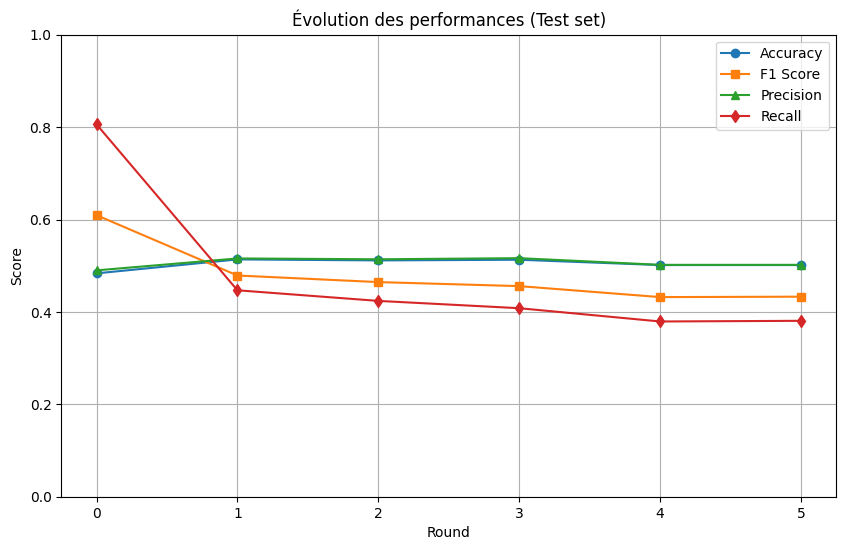

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les métriques
df = pd.read_csv("fl_global_metrics.csv")

# Tracer les courbes de performance
plt.figure(figsize=(10, 6))
plt.plot(df["accuracy"], label="Accuracy", marker="o")
plt.plot(df["f1_score"], label="F1 Score", marker="s")
plt.plot(df["precision"], label="Precision", marker="^")
plt.plot(df["recall"], label="Recall", marker="d")
plt.title("Évolution des performances (Test set)")
plt.xlabel("Round")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


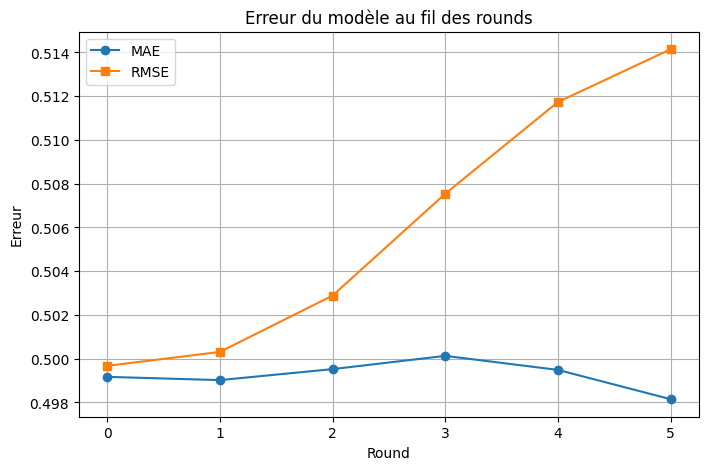

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(df["mae"], label="MAE", marker="o")
plt.plot(df["rmse"], label="RMSE", marker="s")
plt.title("Erreur du modèle au fil des rounds")
plt.xlabel("Round")
plt.ylabel("Erreur")
plt.legend()
plt.grid(True)
plt.show()


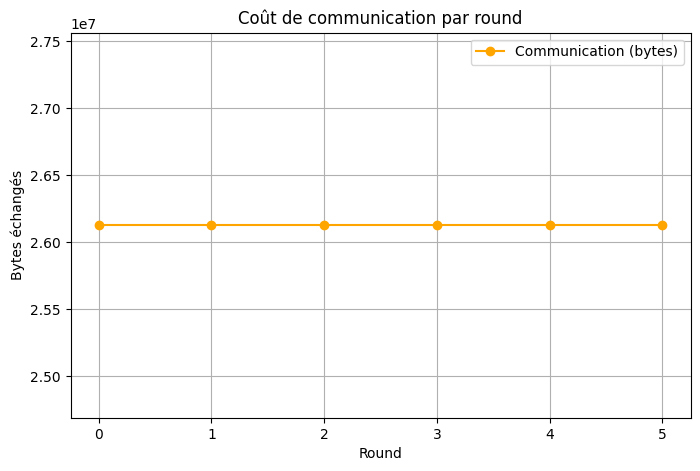

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(df["comm_bytes"], label="Communication (bytes)", color="orange", marker="o")
plt.title("Coût de communication par round")
plt.xlabel("Round")
plt.ylabel("Bytes échangés")
plt.grid(True)
plt.legend()
plt.show()


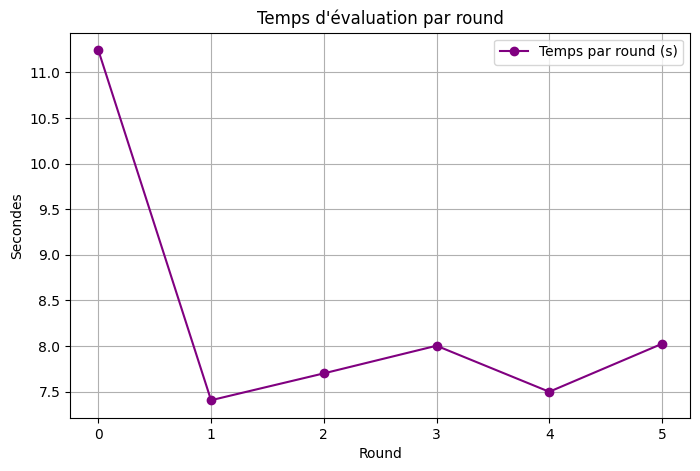

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(df["round_time_sec"], label="Temps par round (s)", color="purple", marker="o")
plt.title("Temps d'évaluation par round")
plt.xlabel("Round")
plt.ylabel("Secondes")
plt.grid(True)
plt.legend()
plt.show()


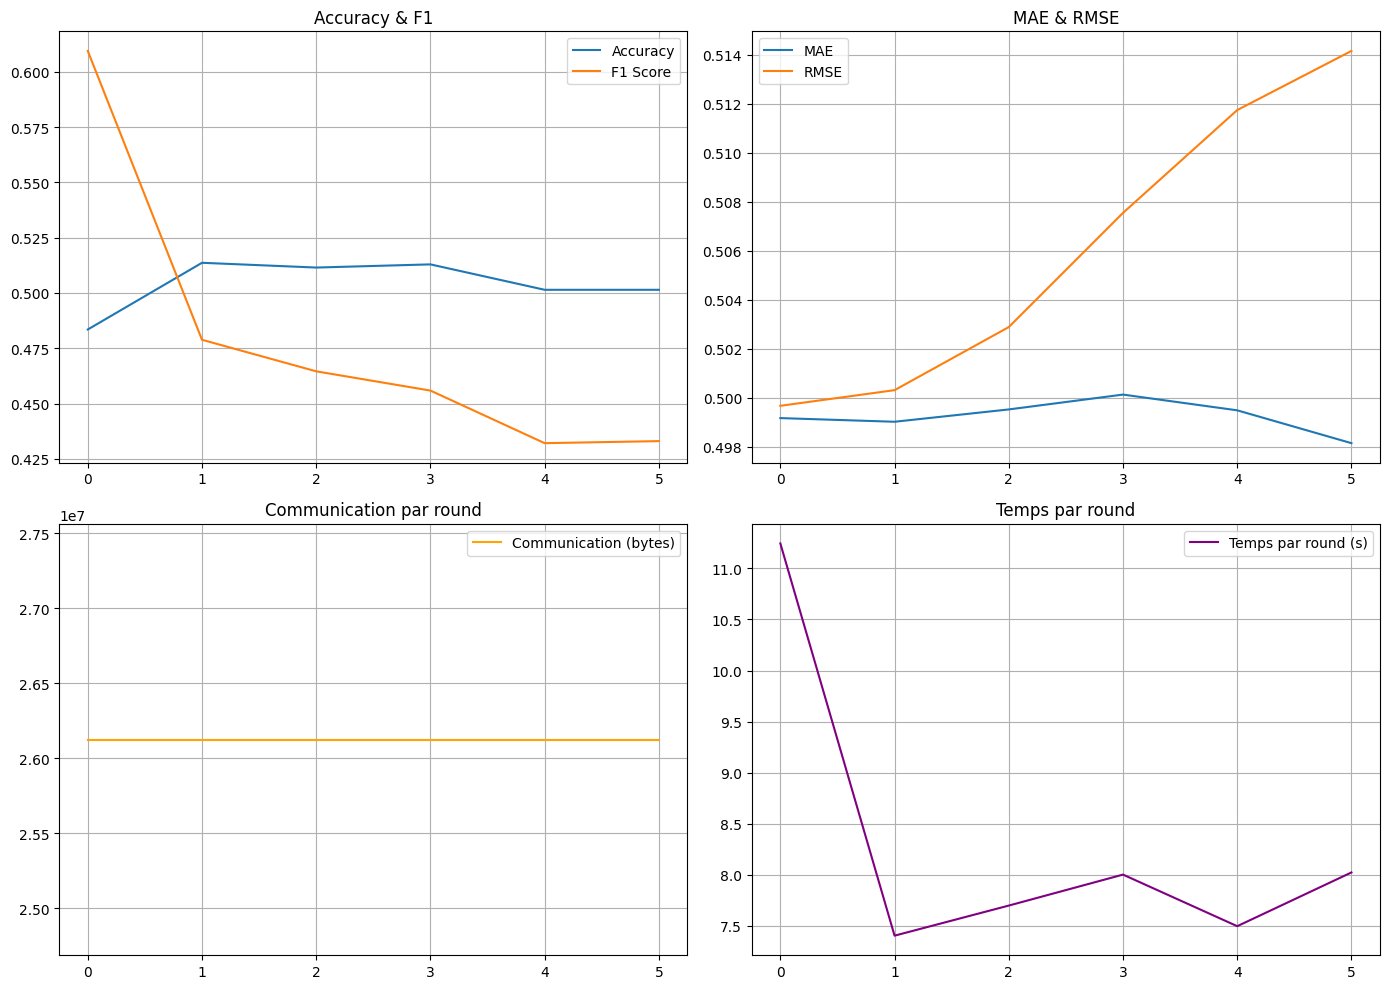

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy & F1
axs[0, 0].plot(df["accuracy"], label="Accuracy")
axs[0, 0].plot(df["f1_score"], label="F1 Score")
axs[0, 0].set_title("Accuracy & F1")
axs[0, 0].legend()
axs[0, 0].grid(True)

# MAE & RMSE
axs[0, 1].plot(df["mae"], label="MAE")
axs[0, 1].plot(df["rmse"], label="RMSE")
axs[0, 1].set_title("MAE & RMSE")
axs[0, 1].legend()
axs[0, 1].grid(True)

# Communication
axs[1, 0].plot(df["comm_bytes"], label="Communication (bytes)", color="orange")
axs[1, 0].set_title("Communication par round")
axs[1, 0].legend()
axs[1, 0].grid(True)

# Round Time
axs[1, 1].plot(df["round_time_sec"], label="Temps par round (s)", color="purple")
axs[1, 1].set_title("Temps par round")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()
